# VGG16
object detection에 필요한 특징을 추출하기 위해 백본으로 사용

### 참고자료
- https://wjunsea.tistory.com/94
- https://hwanny-yy.tistory.com/11
- https://yazaki.tistory.com/24
- https://beginnerdeveloper-lit.tistory.com/158
- https://datasirup.tistory.com/118

### 위성 데이터셋
- https://data.mendeley.com/datasets/bkxj8z84m9/3
- https://www.kaggle.com/datasets/jiayuanchengala/aid-scene-classification-datasets


## 라이브러리 호출

In [2]:
import json
import os

import h5py
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## VGG16 정의

In [9]:
def VGG16():
    model = tf.keras.models.Sequential([
        # input = 224 x 224 x 3

        # 224 x 224 x 64
        layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', input_shape=(224, 224, 3)),
        layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),

        # 112 x 112 x 64
        layers.MaxPool2D((2, 2), padding='same'),

        # 112 x 112 x 128
        layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),

        # 56 x 56 x 128
        layers.MaxPool2D((2, 2), padding='same'),

        # 56 x 56 x 256
        layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),

        # 28 x 28 x 256
        layers.MaxPool2D((2, 2), padding='same'),

        # 28 x 28 x 512
        layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),

        # 14 x 14 x 512
        layers.MaxPool2D((2, 2), padding='same'),

        # 14 x 14 x 512
        layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu'),

        # 7 x 7 x 512
        layers.MaxPool2D((2, 2), padding='same'),

        # 1 x 1 x 25088
        layers.Flatten(),
        layers.Dropout(0.5),

        # 1 x 1 x 4096
        layers.Dense(4096, activation='relu'),

        # 1 x 1 x 4096
        layers.Dense(4096, activation='relu'),

        # 1 x 1 x 1000
        layers.Dense(1000, activation='relu'),

        # 1 x 1 x 2
        layers.Dense(30, activation='softmax'),
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['acc'])

    return model

## 데이터 전처리

In [5]:
train_dataset_path = 'ConTankDataSet/train'
valid_dataset_path = 'ConTankDataSet/valid'
oil_img_path = 'oiltank_dataset/train_images'
oil_label_path = 'oiltank_dataset/train_labels'
container_img_path = 'container_dataset/train_images'
container_label_path = 'container_dataset/train_labels'

In [21]:
# json to csv 함수 정의
def json2csv(fname):
    with open(fname, 'r', encoding='utf-8') as inputFile:
        data = json.load(inputFile)


In [22]:
for i in os.listdir(oil_label_path):
    with open(oil_label_path + f'/{i}') as f:
        jsonData = json.load(f)
        data = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])
        for j, property in enumerate(jsonData['features']):
            data.loc[j] = list(map(float, property['properties']['object_imcoords'].split(sep=',')))
        
        data.to_csv(oil_label_path + '/' + i.split(sep=".")[0]+ '.csv', index=False)

In [24]:
for i in os.listdir(oil_img_path):
    if i[-3:] != 'png':
        os.remove(oil_img_path + f'/{i}')

### strage tank만 자르기

In [201]:
for img_fname in sorted(os.listdir(oil_img_path)):
    img = cv2.imread(oil_img_path + f'/{img_fname}')
    
    tanks = pd.read_csv(oil_label_path + f'/{img_fname.split(sep=".")[0]}.csv')
    for tank_num in range(len(tanks)):
        tank_mat = tanks.loc[tank_num]
        x1, y1, x3, y3 = tank_mat['x1'], tank_mat['y1'], tank_mat['x3'], tank_mat['y3']
        w = int(abs(x1-x3))
        h = int(abs(y3-y1))
        if w == 0:
            w = 1
        elif h == 0:
            h = 1
        img_crop = img[int(min(y1, y3)):int(min(y1, y3))+h, int(min(x1, x3)):int(min(x1, x3))+w]
        cv2.imwrite(train_dataset_path+f'/oiltank/{img_fname.split(sep=".")[0]}_{tank_num}.png', img_crop)

### container 전처리

In [6]:
for fname in os.listdir(container_img_path):
    if fname[-3:] != 'png':
        os.remove(container_img_path + f'/{fname}')

### 너무 작은 데이터 삭제

In [24]:
tmp = os.listdir(train_dataset_path)
tmp.remove('oiltank')
tmp.remove('container')
for img_fname in tmp:
    img = cv2.imread(train_dataset_path + f'/{img_fname}')
    if img.shape[0] < 10 or img.shape[1] < 10:
        os.remove(train_dataset_path + f'/{img_fname}')
    else:
        shutil.move(train_dataset_path + f'/{img_fname}', train_dataset_path + f'/oiltank/{img_fname}')

ConTankDataSet/train/OBJ05501_PS3_K3A_NIA0166_70.png
ConTankDataSet/train/OBJ03728_PS3_K3A_NIA0156_38.png
ConTankDataSet/train/OBJ05501_PS3_K3A_NIA0166_23.png
ConTankDataSet/train/OBJ03563_PS3_K3A_NIA0150_2.png
ConTankDataSet/train/OBJ05532_PS3_K3A_NIA0353_34.png
ConTankDataSet/train/OBJ03720_PS3_K3A_NIA0156_36.png
ConTankDataSet/train/OBJ03785_PS3_K3A_NIA0158_11.png
ConTankDataSet/train/OBJ04545_PS3_K3A_NIA0300_5.png
ConTankDataSet/train/OBJ03619_PS3_K3A_NIA0151_7.png
ConTankDataSet/train/OBJ03547_PS3_K3A_NIA0149_1.png
ConTankDataSet/train/OBJ05428_PS3_K3A_NIA0350_1.png
ConTankDataSet/train/OBJ05284_PS3_K3A_NIA0342_3.png
ConTankDataSet/train/OBJ03702_PS3_K3A_NIA0155_13.png
ConTankDataSet/train/OBJ03720_PS3_K3A_NIA0156_27.png
ConTankDataSet/train/OBJ04560_PS3_K3A_NIA0300_4.png
ConTankDataSet/train/OBJ05506_PS3_K3A_NIA0166_79.png
ConTankDataSet/train/OBJ03547_PS3_K3A_NIA0149_4.png
ConTankDataSet/train/OBJ02634_PS3_K3_NIA0126_16.png
ConTankDataSet/train/OBJ04702_PS3_K3A_NIA0313_15.png
Co

## container 전처리

### json to csv

In [18]:
# json to csv 함수 정의
def json2csv(fname):
    with open(fname, 'r', encoding='utf-8') as inputFile:
        data = json.load(inputFile)

In [19]:
for i in os.listdir(container_label_path):
    with open(container_label_path + f'/{i}') as f:
        jsonData = json.load(f)
        data = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])
        for j, property in enumerate(jsonData['features']):
            data.loc[j] = list(map(float, property['properties']['object_imcoords'].split(sep=',')))
        
        data.to_csv(container_label_path + '/' + i.split(sep=".")[0]+ '.csv', index=False)

In [20]:
for i in os.listdir(container_label_path):
    if i[-3:] != 'csv':
        os.remove(container_label_path + f'/{i}')

### container만 자르기

In [200]:
for img_fname in sorted(os.listdir(container_img_path)):
    img = cv2.imread(container_img_path + f'/{img_fname}')
    
    containers = pd.read_csv(container_label_path + f'/{img_fname.split(sep=".")[0]}.csv')
    for container_num in range(len(containers)):
        container_mat = containers.loc[container_num]
        x1, y1, x3, y3 = container_mat['x1'], container_mat['y1'], container_mat['x3'], container_mat['y3']
        if x1 < 0 or y1 < 0 or x3 < 0 or y3 < 0:
            continue
        w = int(abs(x1-x3))
        h = int(abs(y3-y1))
        if w == 0:
            w = 1
        elif h == 0:
            h = 1
        img_crop = img[int(min(y1, y3)):int(min(y1, y3))+h, int(min(x1, x3)):int(min(x1, x3))+w]
        
        cv2.imwrite(train_dataset_path+f'/container/{img_fname.split(sep=".")[0]}_{container_num}.png', img_crop)

In [49]:
tmp = os.listdir(train_dataset_path+'/container')
for img_fname in tmp:
    img = cv2.imread(train_dataset_path + f'/container/{img_fname}')
    if img.shape[0] < 10 or img.shape[1] < 10:
        os.remove(train_dataset_path + f'/container/{img_fname}')

### storage tank & containers 전처리

In [204]:
con = os.listdir(train_dataset_path + '/container')
tank = os.listdir(train_dataset_path + '/oiltank')

for i in con[:int(len(con)*0.3)]:
    shutil.move(train_dataset_path + f'/container/{i}', valid_dataset_path + f'/container/{i}')

for i in tank[:int(len(tank)*0.3)]:
    shutil.move(train_dataset_path + f'/oiltank/{i}', valid_dataset_path + f'/oiltank/{i}')

In [205]:
# Dataset (storage tank & others)
train_data_generator = ImageDataGenerator(rescale=1. / 255)
train_dataset = train_data_generator.flow_from_directory(train_dataset_path,
                                                         shuffle=True,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical')


valid_data_generator = ImageDataGenerator(rescale=1. / 255)
valid_dataset = valid_data_generator.flow_from_directory(valid_dataset_path,
                                                         shuffle=True,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical')

Found 1414 images belonging to 2 classes.
Found 606 images belonging to 2 classes.


In [203]:
oil = os.listdir(train_dataset_path + '/oiltank')
con = os.listdir(train_dataset_path + '/container')

for i in con[:len(con)-len(oil)]:
    os.remove(train_dataset_path + f'/container/{i}')

print(len(os.listdir(train_dataset_path + '/oiltank')), len(os.listdir(train_dataset_path + '/container')))


1010 10063
1010 1010


### AID Path

In [6]:
aid_path = 'AID'

In [234]:
tmp = os.listdir('AID/train')
tmp.remove('container')
tmp.remove('oiltank')

for i in tmp:
    tmp_l = os.listdir(f'AID/train/{i}')
    os.mkdir(f'AID/valid/{i}')
    for j in tmp_l[:int(len(tmp_l)*0.3)]:
        shutil.move(f'AID/train/{i}/{j}', f'AID/valid/{i}/{j}')



In [7]:
# Dataset (storage tank & others)
train_data_generator = ImageDataGenerator(rescale=1. / 255)
train_dataset = train_data_generator.flow_from_directory(aid_path+'/train',
                                                         shuffle=True,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical')


valid_data_generator = ImageDataGenerator(rescale=1. / 255)
valid_dataset = valid_data_generator.flow_from_directory(aid_path+'/valid',
                                                         shuffle=True,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical')

Found 7889 images belonging to 30 classes.
Found 3381 images belonging to 30 classes.


## 학습

In [10]:
model = VGG16()

checkpoint_filepath = "logs/VGG/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
)

train = model.fit(train_dataset, epochs=100, validation_data=valid_dataset, 
                  callbacks=[
                        checkpoint_callback,
                        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
                    ],)

Epoch 1/100


2023-07-21 03:49:09.952027: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x268c81f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-21 03:49:09.952054: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-07-21 03:49:09.952059: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-07-21 03:49:10.087388: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


247/247 [==============================] - 49s 184ms/step - loss: 3.3800 - acc: 0.0914 - val_loss: 3.3557 - val_acc: 0.0896
Epoch 2/100
247/247 [==============================] - 44s 177ms/step - loss: 3.3357 - acc: 0.0894 - val_loss: 3.3190 - val_acc: 0.0896
Epoch 3/100
247/247 [==============================] - 43s 174ms/step - loss: 3.3128 - acc: 0.0996 - val_loss: 3.2836 - val_acc: 0.1020
Epoch 4/100
247/247 [==============================] - 44s 176ms/step - loss: 3.1524 - acc: 0.1369 - val_loss: 3.0021 - val_acc: 0.1585
Epoch 5/100
247/247 [==============================] - 44s 178ms/step - loss: 2.8495 - acc: 0.1995 - val_loss: 2.7226 - val_acc: 0.2032
Epoch 6/100
247/247 [==============================] - 43s 173ms/step - loss: 2.6006 - acc: 0.2514 - val_loss: 2.3866 - val_acc: 0.3221
Epoch 7/100
247/247 [==============================] - 44s 176ms/step - loss: 2.3865 - acc: 0.3094 - val_loss: 2.2480 - val_acc: 0.3564
Epoch 8/100
247/247 [==============================] - 43s 1

## 평가

Saved Accuracy graph
Saved Loss graph


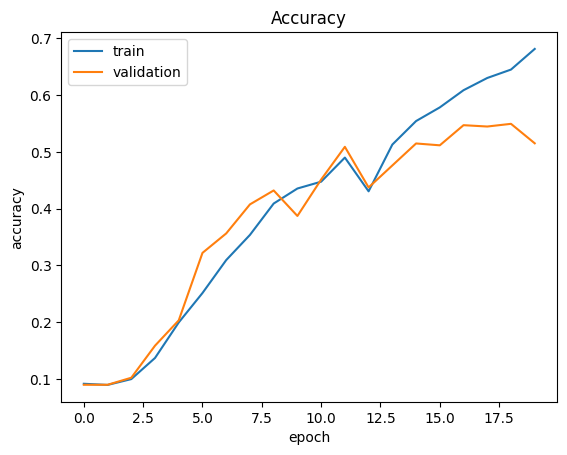

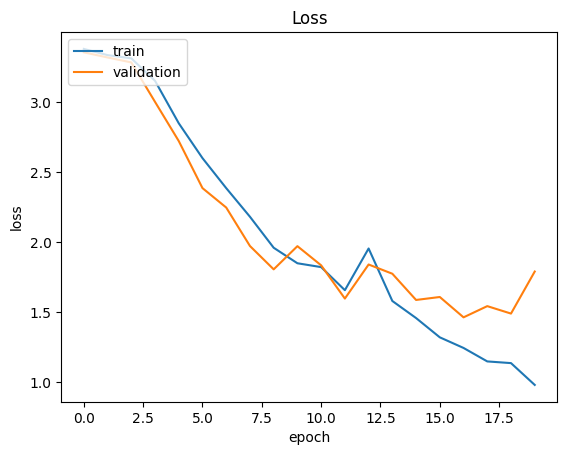

In [11]:
# Accuracy graph
plt.figure(1)
plt.plot(train.history['acc'])
plt.plot(train.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('VGG16_Accuracy_1.png')
print("Saved Accuracy graph")

# Loss graph
plt.figure(2)
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('VGG16_Loss_1.png')
print("Saved Loss graph")

plt.show()

### 모델 저장

In [12]:
train.model.save('VGG16')

INFO:tensorflow:Assets written to: VGG16/assets


INFO:tensorflow:Assets written to: VGG16/assets


: 

In [208]:
tmp = VGG16()

tmp.load_weights(checkpoint_filepath)

In [209]:
loss, acc = tmp.evaluate(valid_dataset)

19/19 [==============================] - 11s 572ms/step - loss: 0.1915 - acc: 0.9208


In [210]:
tmp.save('VGG16')

INFO:tensorflow:Assets written to: VGG16/assets


INFO:tensorflow:Assets written to: VGG16/assets


In [224]:
# test set 생성

test_data_generator = ImageDataGenerator(rescale=1. / 255)
test_dataset = test_data_generator.flow_from_directory('tmp',
                                                         shuffle=True,
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='categorical')

Found 1 images belonging to 1 classes.


In [225]:
a = train.model.predict(test_dataset)

In [226]:
print(a)

[[0.9921835  0.00781645]]
